In [22]:
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib
import matplotlib.pyplot as plt
import os
import json
import datetime

plt.rcParams["figure.figsize"] = (20, 5)

In [3]:
data = np.genfromtxt("../로그 데이터/SEG_SGEMM_result.txt", delimiter="\n", dtype=np.int64)
data

array([ 3196231680, 93292771632, 93293300344, ..., 92658792872,
       92658792864, 92654987192], dtype=int64)

In [4]:
delta = np.array([data[i+1] - data[i] for i in range(int(len(data))-1)])
delta, len(delta)

(array([90096539952,      528712,       73032, ...,    36097352,
                 -8,    -3805672], dtype=int64),
 237194)

In [5]:
data_counts = pd.Series(data=delta.T).value_counts()
data_counts

 0             27460
 4096           7851
 909517620      1849
-909517620      1848
 8192           1481
               ...  
-3833072           1
 349797616         1
-5403768464        1
-568288            1
 7770728296        1
Length: 60247, dtype: int64

In [6]:
def category_by_threshold(data_counts, threshold, sign="over"):
    if sign == "under":
        category = (data_counts < threshold)
    else:
        category = (data_counts > threshold)
    return category.index[category == True]

In [7]:
def tokenizer(data, category, oov=-1):
    data = data.copy()
    mask = np.isin(data, category)
    data[mask == False] = oov
    return data

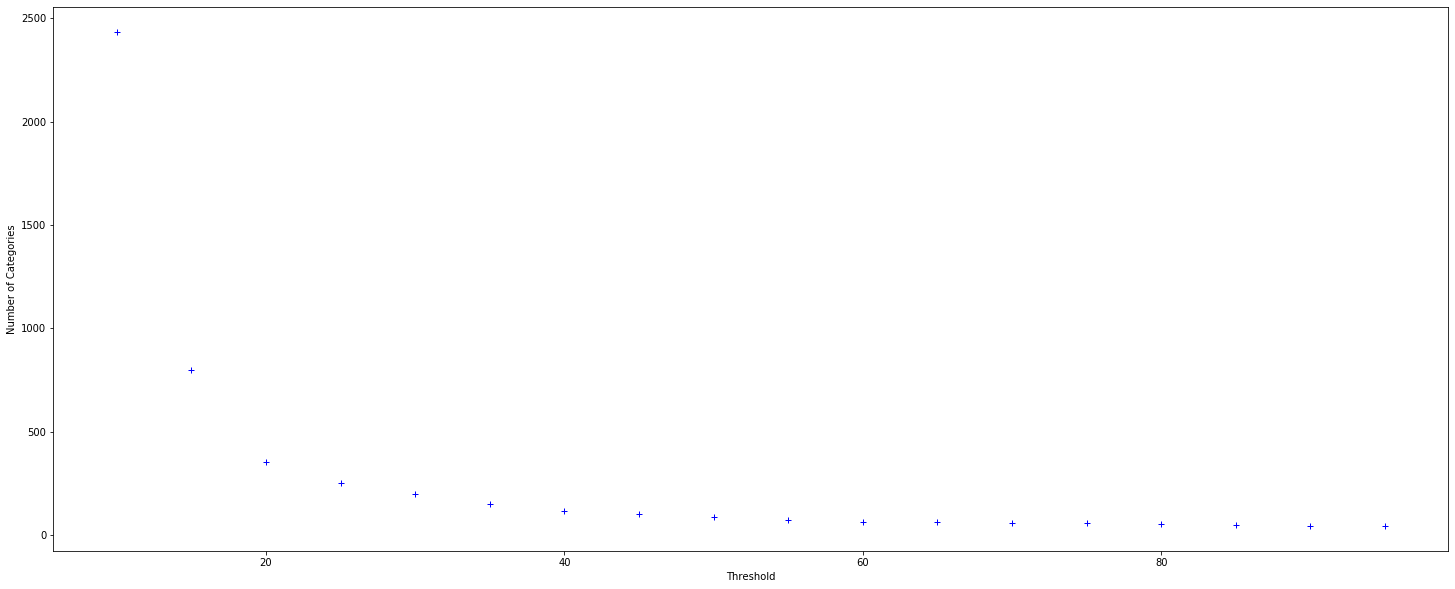

In [8]:
plt.figure(figsize=(25, 10))
data_over_threshold_incremental = pd.DataFrame(data=[(data_counts > i*5).value_counts().values for i in range(2, 20)], columns=["Under Threshold", "Over Threshold"])
plt.plot([i*5 for i in range(2, 20)], data_over_threshold_incremental["Over Threshold"], "b+")
plt.xlabel("Threshold")
plt.ylabel("Number of Categories")
plt.show()

In [9]:
threshold = 15
category_over_threshold = category_by_threshold(data_counts, threshold)
category_over_threshold

Int64Index([         0,       4096,  909517620, -909517620,       8192,
                    -8,      -4096,          8,      12288,       2416,
            ...
                 14520,    4214784,    2785280,    1568768,        192,
              -6922240,     360448,     651264,  -12324864,  -36564992],
           dtype='int64', length=800)

In [10]:
data_counts.index.shape

(60247,)

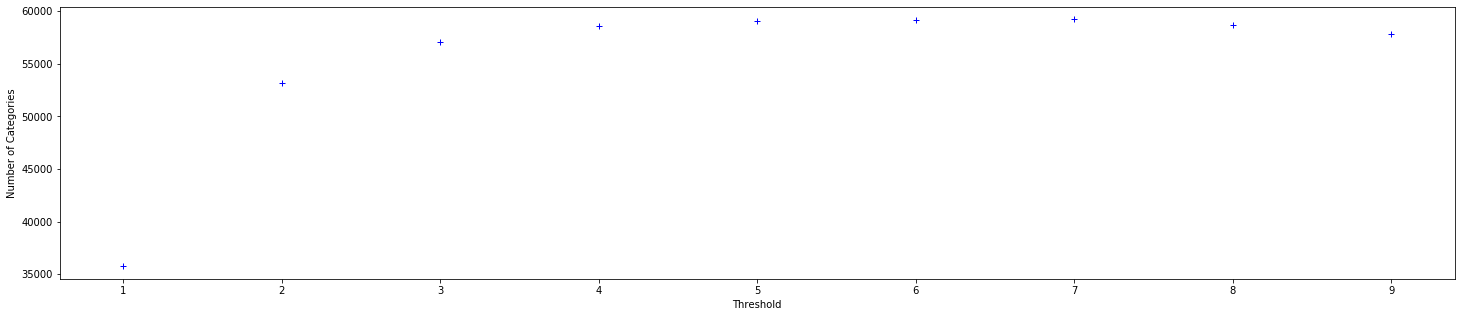

In [11]:
plt.figure(figsize=(25, 5))
data_under_threshold_incremental = pd.DataFrame(data=[(data_counts == i).value_counts().values for i in range(1, 10)], columns=["Under Threshold", "Over Threshold"])
plt.plot([i for i in range(1, 10)], data_under_threshold_incremental["Under Threshold"], "b+")
plt.xlabel("Threshold")
plt.ylabel("Number of Categories")
plt.show()

In [12]:
data_under_threshold_incremental

,Under Threshold,Over Threshold
0,35734,24513
1,53145,7102
2,57031,3216
3,58630,1617
4,59089,1158
5,59171,1076
6,59221,1026
7,58704,1543
8,57851,2396


In [13]:
delta.shape

(237194,)

In [14]:
data_counts.index.shape

(60247,)

In [15]:
(data_counts == 1).value_counts()[True]

35734

In [16]:
(data_counts == 1).value_counts()[True] / delta.shape[0]

0.15065305193217365

In [17]:
# Num of Categories with i counts
[(data_counts == i).value_counts()[True] for i in range(1, 10)]

[35734, 7102, 3216, 1617, 1158, 1076, 1026, 1543, 2396]

In [18]:
# Num of Delta points of given Category
[(data_counts == i).value_counts()[True] * i for i in range(1, 10)]

[35734, 14204, 9648, 6468, 5790, 6456, 7182, 12344, 21564]

In [19]:
total_noise_delta = sum([(data_counts == i).value_counts()[True] * i for i in range(1, 4)])
total_noise_delta, total_noise_delta / delta.shape[0]

(59586, 0.2512120879954805)

In [20]:
def denoise_masking(data, target, oov=-1):
    mask = (pd.Series(data).value_counts() == target)
    noise_index = np.where(np.isin(data, mask.index[mask == True]))[0]
    data[noise_index] = oov
    return data

In [21]:
denoised_delta = denoise_masking(delta.copy(), 1)
denoised_delta = denoise_masking(denoised_delta, 2)
pd.Series(denoised_delta).value_counts()

-1            49947
 0            27460
 4096          7851
 909517620     1849
-909517620     1848
              ...  
-6881544          3
-59170488         3
-232352           3
-102968204        3
-99584            3
Length: 17411, dtype: int64

In [23]:
vocab_size = len(pd.Series(denoised_delta).value_counts().index)
vocab_size

17411

In [39]:
# Int Array to String Array
str_delta = np.char.mod('%d', denoised_delta)
str_delta

array(['-1', '-1', '-1', ..., '-1', '-8', '-1'], dtype='<U12')

In [68]:
tokenizer = keras.preprocessing.text.Tokenizer(vocab_size, oov_token="oov")
tokenizer.fit_on_texts(str_delta)

In [69]:
word_index = tokenizer.word_index
dict(list(word_index.items())[:10])

{'oov': 1,
 '1': 2,
 '0': 3,
 '4096': 4,
 '909517620': 5,
 '8': 6,
 '8192': 7,
 '12288': 8,
 '2416': 9,
 '16384': 10}

In [70]:
transformed_delta = tokenizer.texts_to_sequences(str_delta.tolist())

In [71]:
str_delta[:30]

array(['-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1',
       '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1',
       '-6120', '-1', '-1', '-1', '-1', '-1', '-1', '48', '-1'],
      dtype='<U12')

In [73]:
transformed_delta[:30]

[[2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [994],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [34],
 [2]]

In [74]:
tokenizer.sequences_to_texts(transformed_delta[:10])

['1', '1', '1', '1', '1', '1', '1', '1', '1', '1']

In [75]:
str_data = np.char.mod('%d', delta)
tkr = keras.preprocessing.text.Tokenizer(vocab_size, oov_token="oov")
tkr.fit_on_texts(str_data)

In [76]:
word_index = tkr.word_index
dict(list(word_index.items())[:10])

{'oov': 1,
 '0': 2,
 '4096': 3,
 '909517620': 4,
 '8': 5,
 '8192': 6,
 '12288': 7,
 '2416': 8,
 '16384': 9,
 '24': 10}

In [77]:
tkr.texts_to_sequences(str_data)

[[1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1018],
 [1],
 [1],
 [14013],
 [1],
 [1],
 [1],
 [33],
 [1],
 [1],
 [1],
 [1],
 [1],
 [12409],
 [1],
 [1],
 [12410],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [3],
 [3],
 [3],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [3],
 [3],
 [3],
 [3],
 [3],
 [3],
 [3],
 [3],
 [3],
 [3],
 [3],
 [3],
 [1],
 [1],
 [1],
 [2],
 [1],
 [2],
 [2],
 [1],
 [1],
 [2],
 [11258],
 [2],
 [1],
 [2],
 [2],
 [2],
 [1],
 [2],
 [823],
 [11259],
 [1],
 [1],
 [2],
 [2],
 [2],
 [2],
 [2],
 [1],
 [2],
 [11260],
 [2],
 [1],
 [1],
 [1],
 [2],
 [2],
 [1],
 [2],
 [1],
 [11261],
 [2],
 [2],
 [2],
 [1],
 [2],
 [1],
 [2],
 [1],
 [2],
 [2],
 [2],
 [2],
 [1],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [1],
 [2],
 [2],
 [2],
 [19],
 [1],
 [2],
 [1],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [20],
 [2],
 [2],
 [1],
 [2],
 [2462],
 [2],
 [5],
 [2],
 [14014],
 [1],
 [2],
 [19],
 [1],
 [1],
 [14015]

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(denoised_delta, test_size=0.25, shuffle=False)
train_set, test_set

pd.DataFrame(train_set).to_csv("data/SEG_2_train_set.csv", index=False, header=False)
pd.DataFrame(test_set).to_csv("data/SEG_2_test_set.csv", index=False, header=False)